In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

* We start with the import of the the functions that we are going to use 
# We import the standard Keras library




In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

* NOTE: each function will be explained when used.


# Loading the train and test files.



In [ ]:
train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [ ]:
train.head()


In [ ]:
test.head()

A common preprocessing step is to check for nulls, and fill the null values with something before proceeding to the next steps. If you leave the null values intact, it will affect the model results

In [ ]:
train.isnull().any(),test.isnull().any()


Looks like we don't need to deal with the null values.




Let's clean the text 

* Punctuation remove

In [ ]:
#string.punctuation


In [ ]:
#def remove_punct(text):
#    text  = "".join([char for char in text if char not in string.punctuation])
 #   text = re.sub('[0-9]+', '', text)
  #  text = re.sub('\n', '', text)
   # text = re.sub('\t', '', text)
    #return text


#train['comment_text'] = train['comment_text'].apply(lambda x: remove_punct(x))
#test['comment_text'] = test['comment_text'].apply(lambda x: remove_punct(x))




* removing uppercases

In [ ]:
def lower(text):
    lowercase_text = [word.lower() for word in text.split()]
    text=" ".join(lowercase_text)
    return text

In [ ]:
train['comment_text'] = train['comment_text'].apply(lambda x: lower(x))
test['comment_text'] = test['comment_text'].apply(lambda x: lower(x))


Removing punctuations and lower cases will lower the score after checking the data more i found out that the punctuations are used to express such bad words for example s#$t


In [ ]:
train.head()

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

the dependent variables are in the training set itself so we need to split them up, into X and Y sets.

we going to  feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is.

So we are going to do a natural language processing to the comments which are simply explained as :

1. Tokenization - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
2. Indexing - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
3. Index Representation- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

Note that we have to define the number of unique words in our dictionary when tokenizing the sentences
* we picked 20000 

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

the occurrence and the index of each words in the dictionary:
it takes alot of time to execute and alot of output is shown uncomment to check

In [ ]:
#for occurence of words
#tokenizer.word_counts
#for index of words
#tokenizer.word_index

checking "list_tokenized_train"  you will see that Keras has turned our words into index representation for us



In [ ]:
list_tokenized_train[:1]

And we have to feed a stream of data that has a consistent length(fixed number of features) 
and here we will face a problem since the comments aren't all equal so
example:

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2]

as a solution we will use padding that will make all comments having the same length by filling with missing values with zeros to get :

Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]

Comment #2: [1,2,0,0,0,0,0,0,0,0,0,0,0,0]

and now another problem how can we choose the fixed number of features since  if you put it too short, you might lose some useful feature that could cost you some accuracy points down the path.If you put it too long, your LSTM cell will have to be larger to store the possible values or states.




One of the ways to go about it is to see the distribution of the number of words in sentences.

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [ ]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

As we can see, most of the sentence length is about 30+. We could set the "maxlen" to about 50.
and to avoid any kind of information loss we can extend it to 200

In [ ]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

our comments are now econded and ready to fed to the model


# Building model

General architecture of our model 

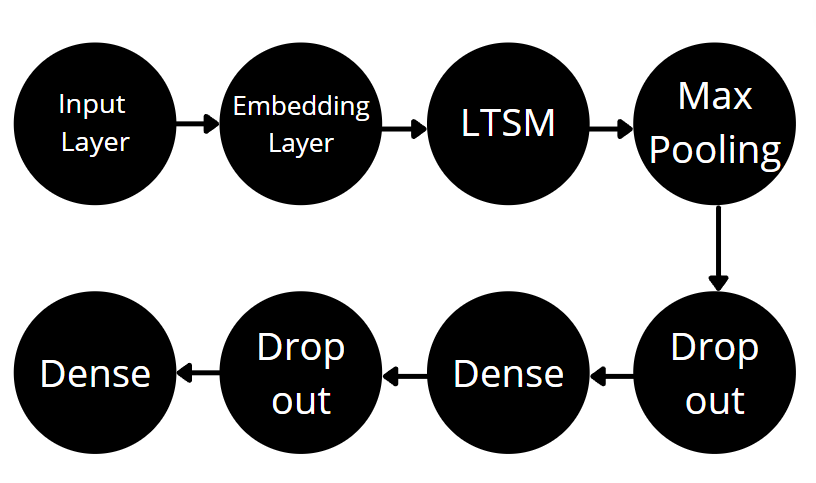

**Input Layer**
* the inputs into our networks are our list of encoded sentences. We begin our defining an Input layer that accepts a list of sentences that has a dimension of 200.

In [ ]:
inp = Input(shape=(maxlen, ))

By indicating an empty space after comma, we are telling Keras to infer the number automatically.

**Embedding layer**

Next, we pass it to our Embedding layer, where we project the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with instead of  using one-hot encoding to represent the words in our sentence.

In [ ]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

*  the embedding size (vector size) is a parameter that you can tune and experiment
*  embedding function will return us a  3-D tensor
*  Tensors are simply mathematical objects that can be used to describe physical properties, just like   scalars and vectors. In fact tensors are merely a generalisation of scalars and vectors; a scalar  is a zero rank tensor, and a vector is a first rank tensor.

* Next, we feed this Tensor into the LSTM layer. We set the LSTM to produce an output that has a dimension of 60 and want it to return the whole unrolled sequence of results
* LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, and you would take the final output after X number of recursion. But depending on use cases, you might want to take the unrolled, or the outputs of each recursion as the result to pass to the next layer. And this is the case.

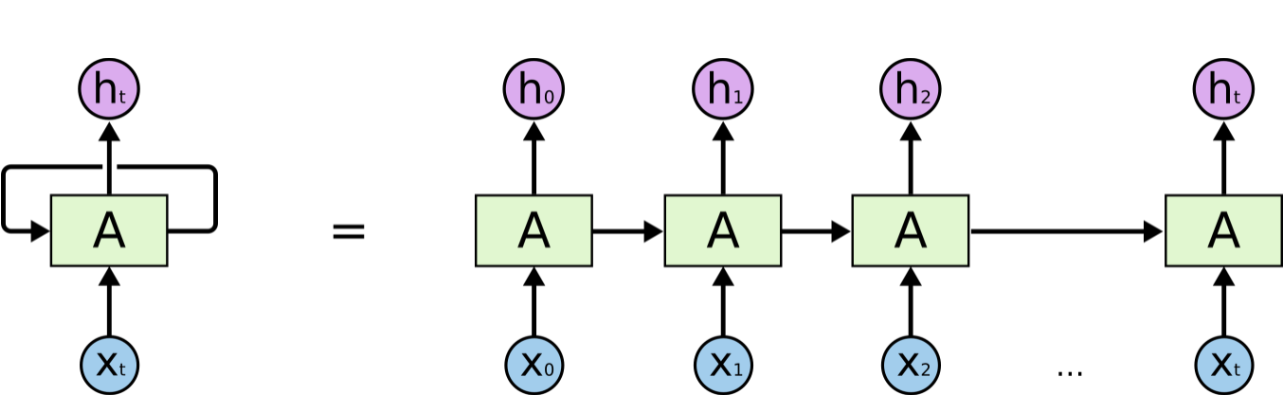

LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs]. Batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, or it could be pictured as the number of "A"s in the above picture. Lastly, number of inputs is the number of variables(number of words in each sentence in our case) you pass into LSTM as pictured in "x" above.

In [ ]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

What it does is going through the samples, recursively run the LSTM model for many time (depending on the values of the tensor passed from the last cell stocked in x) , passing in the coordinates of the words each time. And because we want the unrolled version, we will receive a Tensor shape of (None, 1, 1), where 60 is the output dimension we have defined.

**Max Pooling**

Before we could pass the output to a normal layer, we need to reshape the 3D tensor into a 2D one. We reshape carefully to avoid throwing away data that is important to us, and ideally we want the resulting data to be a good representative of the original data.

Therefore, we use a Global Max Pooling layer which is traditionally used in CNN problems to reduce the dimensionality of image data. In simple terms, we go through each patch of data, and we take the maximum values of each patch. These collection of maximum values will be a new set of down-sized data we can use.

In [ ]:
x = GlobalMaxPool1D()(x)

Now we move to regularization our neurol network (to reduce overfitting by using dropout and dense layers)

having a 2D tensor, we pass it to a Dropout layer which indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.



In [ ]:
x = Dropout(0.1)(x)

We set the dropout layer to drop out 10% of the nodes.

After a drop out layer, we connect the output of drop out layer to a densely connected layer and the output passes through a RELU function. In short, this is what it does:
Activation( (Input X Weights) + Bias)


The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

In [ ]:
x = Dense(50, activation="relu")(x)


We feed the output into a Dropout layer again.



In [ ]:
x = Dropout(0.1)(x)


Finally, we feed the output into a Sigmoid layer. The reason why sigmoid is used is because we are trying to achieve a binary classification(1,0) for each of the 6 labels, and the sigmoid function will squash the output between the bounds of 0 and 1.



In [ ]:
x = Dense(6, activation="sigmoid")(x)


All is left is to define the inputs, outputs and configure the learning process. We have set our model to optimize our loss function using Adam optimizer, define the loss function to be "binary_crossentropy" since we are tackling a binary classification.And learning rateby his default value  set at 0.001.

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

It's finally time to put our model to the test. We'll feed in a list of 32 padded, indexed sentence for each batch and split 10% of the data as a validation set. This validation set will be used to assess whether the model has overfitted, for each batch. The model will also run for 2 epochs ( in other word it will run through the whole training set 2 times ).

In [ ]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

 lists out all your layer outputs

In [ ]:
model.summary()

Predicting with our model

In [ ]:
sub=pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip')


In [ ]:
sub.head()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
preds = model.predict(X_te, batch_size=1024)
sub[list_classes] = preds

In [ ]:
sub.head()

In [ ]:
sub.to_csv('sample_submission.csv',index=False)